# Validation Layer

## **Description:**

- Now you have to create validation schema and produce simple model running on it
    - Create a validation class
    - Create a simpe model
    - Create a simpe feature extraction step
- No extensive modeling or feature extraction is required, we need just to ensure our modeling step is trustworthy:
    - We don't have any target leakage
    - Our validation results are very close to the production behaviour
    - We have enough validation data to rank our model results
- Prepare a simple picture that would describe your schema:
    - Decalre Train/Validation/Test splits
    - Define validation approach
    - Define the way you exrtact features that won't have target or data leakage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import BaseCrossValidator
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

import sys
sys.path.append('../')
import scripts.validate as validate # validate.py module

## Load and transform **train, test** datasets

In [2]:
train_df = pd.read_csv('../data/result_train.csv')
test_df = pd.read_csv('../data/result_test.csv')

In [4]:
float_columns = train_df.select_dtypes(include=np.number).columns.tolist()
object_columns = train_df.select_dtypes(include=object).columns.tolist()

train_df = validate.transform_df_types(train_df, int_columns=[], float_columns=float_columns, object_columns=object_columns)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608724 entries, 0 to 1608723
Data columns (total 37 columns):
 #   Column                          Non-Null Count    Dtype   
---  ------                          --------------    -----   
 0   date_block_num                  1608724 non-null  float32 
 1   shop_id                         1608724 non-null  float32 
 2   item_id                         1608724 non-null  float32 
 3   item_cnt_month                  1608724 non-null  float32 
 4   item_price                      1608724 non-null  float32 
 5   month                           1608724 non-null  float32 
 6   year                            1608724 non-null  float32 
 7   item_name                       1608724 non-null  category
 8   item_category_id                1608724 non-null  float32 
 9   item_category_name              1608724 non-null  category
 10  shop_name                       1608724 non-null  category
 11  months_since_last_sale          1608724 non-null  

In [5]:
float_columns = test_df.select_dtypes(include=np.number).columns.tolist()
object_columns = test_df.select_dtypes(include=object).columns.tolist()

test_df = validate.transform_df_types(test_df, int_columns=[], float_columns=float_columns, object_columns=object_columns)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214284 entries, 0 to 214283
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   ID                              214284 non-null  float32 
 1   shop_id                         214284 non-null  float32 
 2   item_id                         214284 non-null  float32 
 3   item_name                       214284 non-null  category
 4   item_category_id                214284 non-null  float32 
 5   item_category_name              214284 non-null  category
 6   shop_name                       214284 non-null  category
 7   months_since_last_sale          214284 non-null  float32 
 8   revenue_lag_1                   214284 non-null  float32 
 9   revenue_lag_2                   214284 non-null  float32 
 10  revenue_lag_3                   214284 non-null  float32 
 11  revenue_lag_6                   214284 non-null  float32 
 12  re

## Build a simple validation split class

In [6]:
class TimeSeriesSplit(BaseCrossValidator):
    """
    The splits are created basing on the 'date_block_num' feature

    Attributes:
        n_splits: the number of train:test pairs to return
        trait_start: first month number to be included in splits
    """

    def __init__(self, n_splits=5, shuffle=False, random_state=None, train_start=0):
        self.n_splits = n_splits
        self.train_start = train_start
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None, method='expanding'):
        n_months = X['date_block_num'].max() + 1
        
        if method == 'expanding':

            for i in range(self.n_splits, 0, -1):
                train_idx = (X['date_block_num'] < n_months - i) & (X['date_block_num'] >= self.train_start)
                test_idx = X['date_block_num'] == n_months - i

                yield train_idx, test_idx
        
        elif method == 'sliding':

            m_in_split = n_months // self.n_splits # number of months in a single split (perhaps, except for the last one)

            for i in range(1, self.n_splits):
                train_idx = (X['date_block_num'] < i * m_in_split - 1) & (X['date_block_num'] >= m_in_split * (i - 1))
                test_idx = X['date_block_num'] == i * m_in_split - 1

                yield train_idx, test_idx
            
            train_idx = (X['date_block_num'] < n_months - 1) & (X['date_block_num'] >= m_in_split * (self.n_splits - 1)) # all indexes left go to the last block
            test_idx = X['date_block_num'] == n_months - 1

            yield train_idx, test_idx

        else:
            
            raise ValueError("'method' parameter should be 'expanding' or 'sliding'")

In [7]:
def train_xgboost(X, y, cv_method='expanding', return_scores=False, return_model=False, cv_n_splits=5,
                   n_estimators=1000, max_depth=7, learning_rate=0.05, early_stopping_rounds=30, subsample=0.8, colsample_bytree=0.8):
    
    """
    Returns on of these: 
        - None
        - model
        - scores
        - model, scores
    """

    scores = []
    tscv = TimeSeriesSplit(n_splits=cv_n_splits)

    for train_idx, test_idx in tscv.split(X, method=cv_method):
        X_new = X.copy()
        X_new.drop('date_block_num', axis=1, inplace=True)
        X_train, X_test = X_new[train_idx], X_new[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = XGBRegressor(
            max_depth=max_depth,
            n_estimators=n_estimators,
            learning_rate=learning_rate,    
            eval_metric="rmse",
            early_stopping_rounds=early_stopping_rounds,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42
        )

        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

        y_pred = model.predict(X_test)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)

        print(f"RMSE: {score:.2f}\n")
    
    print(f"Average RMSE: {np.mean(scores):.2f}")

    if return_scores or return_model:
        to_return = []
        if return_model: to_return.append(model)
        if return_scores: to_return.append(scores)
        return tuple(to_return)

### Check how **split_expanding(df)** works

In [8]:
tscv = TimeSeriesSplit(n_splits=5)

for train_idx, test_idx in tscv.split(train_df, method='expanding'):
    train = train_df[train_idx]
    test = train_df[test_idx]
    print("Train set months:", train['date_block_num'].min(), train['date_block_num'].max())
    print("Test set months", test['date_block_num'].min(), test['date_block_num'].max())
    print()

Train set months: 0.0 28.0
Test set months 29.0 29.0

Train set months: 0.0 29.0
Test set months 30.0 30.0

Train set months: 0.0 30.0
Test set months 31.0 31.0

Train set months: 0.0 31.0
Test set months 32.0 32.0

Train set months: 0.0 32.0
Test set months 33.0 33.0



### Check how **split_sliding(df)** works

In [9]:
tscv = TimeSeriesSplit(n_splits=5)

for train_idx, test_idx in tscv.split(train_df, method='sliding'):
    train = train_df[train_idx]
    test = train_df[test_idx]
    print("Train set months:", train['date_block_num'].min(), train['date_block_num'].max())
    print("Test set months", test['date_block_num'].min(), test['date_block_num'].max())
    print()

Train set months: 0.0 4.0
Test set months 5.0 5.0

Train set months: 6.0 10.0
Test set months 11.0 11.0

Train set months: 12.0 16.0
Test set months 17.0 17.0

Train set months: 18.0 22.0
Test set months 23.0 23.0

Train set months: 24.0 32.0
Test set months 33.0 33.0



## Clean train set from unneeded columns

In [10]:
train = train_df.select_dtypes(include=np.number)
y = train['item_cnt_month']
X = train.drop(['item_cnt_month', 'item_price', 'revenue', 'avg_item_price'], axis=1, inplace=False)

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608724 entries, 0 to 1608723
Data columns (total 30 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   date_block_num                  1608724 non-null  float32
 1   shop_id                         1608724 non-null  float32
 2   item_id                         1608724 non-null  float32
 3   month                           1608724 non-null  float32
 4   year                            1608724 non-null  float32
 5   item_category_id                1608724 non-null  float32
 6   months_since_last_sale          1608724 non-null  float32
 7   revenue_lag_1                   1608724 non-null  float32
 8   revenue_lag_2                   1608724 non-null  float32
 9   revenue_lag_3                   1608724 non-null  float32
 10  revenue_lag_6                   1608724 non-null  float32
 11  revenue_lag_12                  1608724 non-null  float32
 12  

### It's important to note, that before the training process we need to remove the **date_block_num** column

## Train simple model

## Use XGBoost as a first model

In [14]:
# train_xgboost(X, y)

[0]	validation_0-rmse:2.55701	validation_1-rmse:2.17882
[1]	validation_0-rmse:2.51195	validation_1-rmse:2.13405
[2]	validation_0-rmse:2.46729	validation_1-rmse:2.09141
[3]	validation_0-rmse:2.42630	validation_1-rmse:2.05260
[4]	validation_0-rmse:2.38973	validation_1-rmse:2.01709
[5]	validation_0-rmse:2.35401	validation_1-rmse:1.98276
[6]	validation_0-rmse:2.32216	validation_1-rmse:1.95224
[7]	validation_0-rmse:2.29753	validation_1-rmse:1.92655
[8]	validation_0-rmse:2.26944	validation_1-rmse:1.90219
[9]	validation_0-rmse:2.24795	validation_1-rmse:1.88081
[10]	validation_0-rmse:2.22308	validation_1-rmse:1.85758
[11]	validation_0-rmse:2.20058	validation_1-rmse:1.83543
[12]	validation_0-rmse:2.18447	validation_1-rmse:1.81918
[13]	validation_0-rmse:2.16466	validation_1-rmse:1.80220
[14]	validation_0-rmse:2.14616	validation_1-rmse:1.78680
[15]	validation_0-rmse:2.12929	validation_1-rmse:1.77231
[16]	validation_0-rmse:2.11382	validation_1-rmse:1.75820
[17]	validation_0-rmse:2.09966	validation

# Use XGBoost with sliding window

In [16]:
# train_xgboost(X, y, cv_method='sliding', cv_n_splits=3)

[0]	validation_0-rmse:2.50131	validation_1-rmse:2.87527
[1]	validation_0-rmse:2.46308	validation_1-rmse:2.82861
[2]	validation_0-rmse:2.42121	validation_1-rmse:2.78498
[3]	validation_0-rmse:2.38270	validation_1-rmse:2.74082
[4]	validation_0-rmse:2.35059	validation_1-rmse:2.70133
[5]	validation_0-rmse:2.31740	validation_1-rmse:2.66727
[6]	validation_0-rmse:2.28763	validation_1-rmse:2.62964
[7]	validation_0-rmse:2.26517	validation_1-rmse:2.60319
[8]	validation_0-rmse:2.23821	validation_1-rmse:2.57638
[9]	validation_0-rmse:2.21912	validation_1-rmse:2.55429
[10]	validation_0-rmse:2.19591	validation_1-rmse:2.52824
[11]	validation_0-rmse:2.17447	validation_1-rmse:2.50695
[12]	validation_0-rmse:2.15910	validation_1-rmse:2.49011
[13]	validation_0-rmse:2.14045	validation_1-rmse:2.46683
[14]	validation_0-rmse:2.12352	validation_1-rmse:2.44592
[15]	validation_0-rmse:2.10726	validation_1-rmse:2.42851
[16]	validation_0-rmse:2.09306	validation_1-rmse:2.41142
[17]	validation_0-rmse:2.07862	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=30,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### As we can see, **sliding window validation** doesn't produce enough **train data** in a single split to achieve a good model quality

## Try deleting highly correlated features and check if this improves the model quality

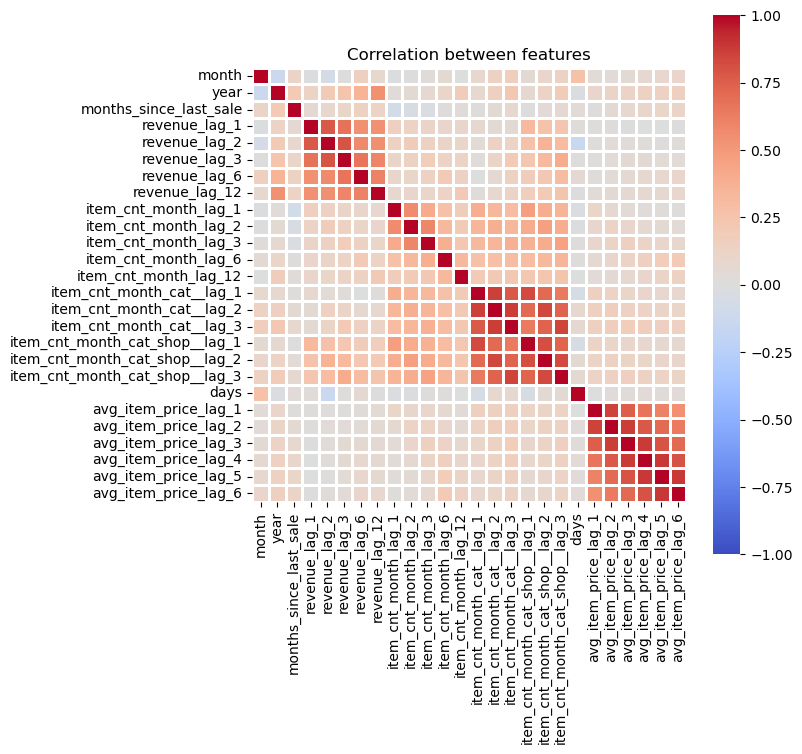

In [11]:
# import seaborn as sns

# numeric_train_df = X.copy()
# numeric_train_df.drop(['date_block_num', 'item_id', 'item_category_id', 'shop_id'], axis=1, inplace=True)
# f, ax = plt.subplots()
# f.set_size_inches(7, 7)
# ax.set_title("Correlation between features")
# sns.heatmap(numeric_train_df.corr(), vmin=-1, vmax=1, center=0, cmap='coolwarm', linewidths=2, square=True);

In [12]:
X.columns

Index(['date_block_num', 'shop_id', 'item_id', 'month', 'year',
       'item_category_id', 'months_since_last_sale', 'revenue_lag_1',
       'revenue_lag_2', 'revenue_lag_3', 'revenue_lag_6', 'revenue_lag_12',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'item_cnt_month_cat__lag_1', 'item_cnt_month_cat__lag_2',
       'item_cnt_month_cat__lag_3', 'item_cnt_month_cat_shop__lag_1',
       'item_cnt_month_cat_shop__lag_2', 'item_cnt_month_cat_shop__lag_3',
       'days', 'avg_item_price_lag_1', 'avg_item_price_lag_2',
       'avg_item_price_lag_3', 'avg_item_price_lag_4', 'avg_item_price_lag_5',
       'avg_item_price_lag_6'],
      dtype='object')

In [13]:
X_less_corr = X.copy()
X_less_corr.drop(['revenue_lag_2', 'revenue_lag_3', 'item_cnt_month_cat__lag_2', 'item_cnt_month_cat__lag_3', 
                  'item_cnt_month_cat_shop__lag_2', 'item_cnt_month_cat_shop__lag_3', 'avg_item_price_lag_3', 'avg_item_price_lag_4', 'avg_item_price_lag_5'], axis=1, inplace=True)

In [20]:
# model = train_xgboost(X_less_corr, y, return_model=True)

[0]	validation_0-rmse:2.55678	validation_1-rmse:2.18266
[1]	validation_0-rmse:2.50915	validation_1-rmse:2.13972
[2]	validation_0-rmse:2.46516	validation_1-rmse:2.09983
[3]	validation_0-rmse:2.43261	validation_1-rmse:2.06517
[4]	validation_0-rmse:2.39484	validation_1-rmse:2.02773
[5]	validation_0-rmse:2.35998	validation_1-rmse:1.99203
[6]	validation_0-rmse:2.32702	validation_1-rmse:1.95984
[7]	validation_0-rmse:2.29715	validation_1-rmse:1.93368
[8]	validation_0-rmse:2.26929	validation_1-rmse:1.90666
[9]	validation_0-rmse:2.24447	validation_1-rmse:1.88357
[10]	validation_0-rmse:2.21983	validation_1-rmse:1.86048
[11]	validation_0-rmse:2.19776	validation_1-rmse:1.83952
[12]	validation_0-rmse:2.18092	validation_1-rmse:1.82219
[13]	validation_0-rmse:2.16177	validation_1-rmse:1.80467
[14]	validation_0-rmse:2.14413	validation_1-rmse:1.78800
[15]	validation_0-rmse:2.12812	validation_1-rmse:1.77518
[16]	validation_0-rmse:2.11299	validation_1-rmse:1.76083
[17]	validation_0-rmse:2.09898	validation

### Deleting 9 highly-correlated features from the dataset didn't worsen the score (1.66 now vs 1.68 then). I will keep the dataset in this form for further work

## Before calculating feature importances, I'll tune hyperparameters of XGBoost model

I'll do this first because feature importance information is not relevant when measured on a bad model

In [14]:
from skopt import BayesSearchCV
from xgboost import XGBRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# # Generate a synthetic regression dataset

# Define the parameter search space
search_space = {
    'n_estimators': (50, 500),
    'max_depth': (3, 15),
    'learning_rate': (0.01, 0.3, 'log-uniform'),  # Log-uniform distribution for learning rate
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0)
}

# Initialize the model
model = XGBRegressor(random_state=42)

cv_custom = TimeSeriesSplit(n_splits=3)

# Initialize the BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=search_space,
    n_iter=10,  # Number of parameter combinations to try
    cv=cv_custom,  # 5-fold cross-validation
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

In [15]:
# Perform the search and store results manually in a loop-like manner
results = []

bayes_search.fit(X_less_corr, y)
best_params = bayes_search.best_params_
best_score = bayes_search.best_score_
    
# # Evaluate on the test set
# y_pred = bayes_search.best_estimator_.predict(X_test)
# test_mse = mean_squared_error(y_test, y_pred)
    
# Store the results
results.append({
    'params': best_params,
    'cv_rmse': best_score,
})
print(f"Best CV negative RMSE = {best_score}")

# Sort and display the best result
results = sorted(results, key=lambda x: x['cv_rmse'], reverse=True)
print("Best parameters:", results[0]['params'])
print("Best CV negative RMSE:", results[0]['cv_rmse'])

Best CV negative MSE = -1.7575781345367432
Best parameters: OrderedDict([('colsample_bytree', 0.9249583953429453), ('learning_rate', 0.01794217698903441), ('max_depth', 10), ('n_estimators', 411), ('subsample', 0.8092209312217534)])
Best CV negative MSE: -1.7575781345367432


In [36]:
results

[{'params': OrderedDict([('colsample_bytree', 0.9249583953429453),
               ('learning_rate', 0.01794217698903441),
               ('max_depth', 10),
               ('n_estimators', 411),
               ('subsample', 0.8092209312217534)]),
  'cv_rmse': -1.7575781345367432}]

## Use the parameters we got

In [16]:
model_best, scores = train_xgboost(X_less_corr, y, return_scores=True, return_model=True, cv_n_splits=5, n_estimators=411, learning_rate=0.01794, max_depth=10, subsample=0.8092, colsample_bytree=0.92496)

[0]	validation_0-rmse:2.58703	validation_1-rmse:2.21093
[1]	validation_0-rmse:2.56658	validation_1-rmse:2.19334
[2]	validation_0-rmse:2.54687	validation_1-rmse:2.17622
[3]	validation_0-rmse:2.52753	validation_1-rmse:2.15906
[4]	validation_0-rmse:2.50883	validation_1-rmse:2.14209
[5]	validation_0-rmse:2.49072	validation_1-rmse:2.12588
[6]	validation_0-rmse:2.47276	validation_1-rmse:2.11068
[7]	validation_0-rmse:2.45535	validation_1-rmse:2.09546
[8]	validation_0-rmse:2.43845	validation_1-rmse:2.07975
[9]	validation_0-rmse:2.42212	validation_1-rmse:2.06593
[10]	validation_0-rmse:2.40616	validation_1-rmse:2.05218
[11]	validation_0-rmse:2.39071	validation_1-rmse:2.03945
[12]	validation_0-rmse:2.37537	validation_1-rmse:2.02697
[13]	validation_0-rmse:2.36068	validation_1-rmse:2.01416
[14]	validation_0-rmse:2.34623	validation_1-rmse:2.00092
[15]	validation_0-rmse:2.33231	validation_1-rmse:1.98972
[16]	validation_0-rmse:2.31862	validation_1-rmse:1.97739
[17]	validation_0-rmse:2.30531	validation

## Try to use XGBoost feature importance information to find relevant features 

I will use the model left from the first XGboost training process

In [17]:
from xgboost import plot_importance

def plot_features(booster, figsize, importance_type="weight"):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, importance_type=importance_type, values_format="{v:.2f}")

There are 3 ways of how the importance is calculated:
- ”weight” is the number of times a feature appears in a tree
- ”gain” is the average gain of splits which use the feature
- ”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

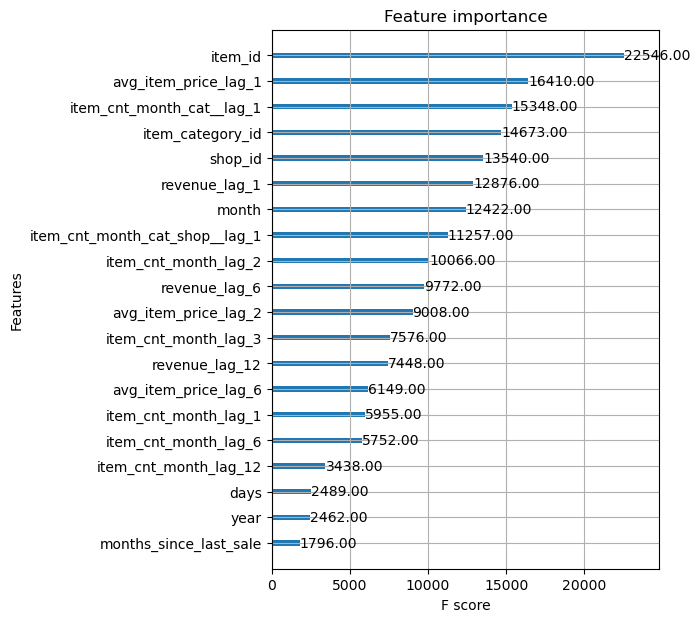

In [18]:
plot_features(model_best, (5, 7), importance_type="weight");

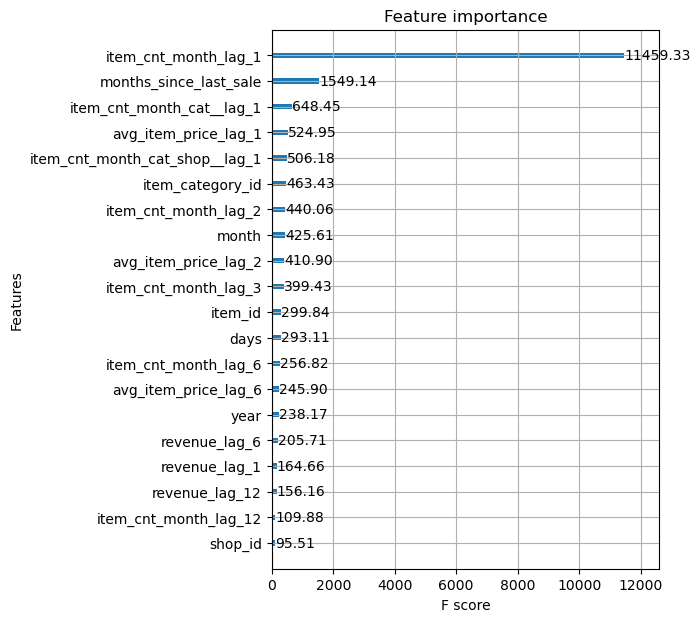

In [19]:
plot_features(model_best, (5, 7), importance_type="gain");

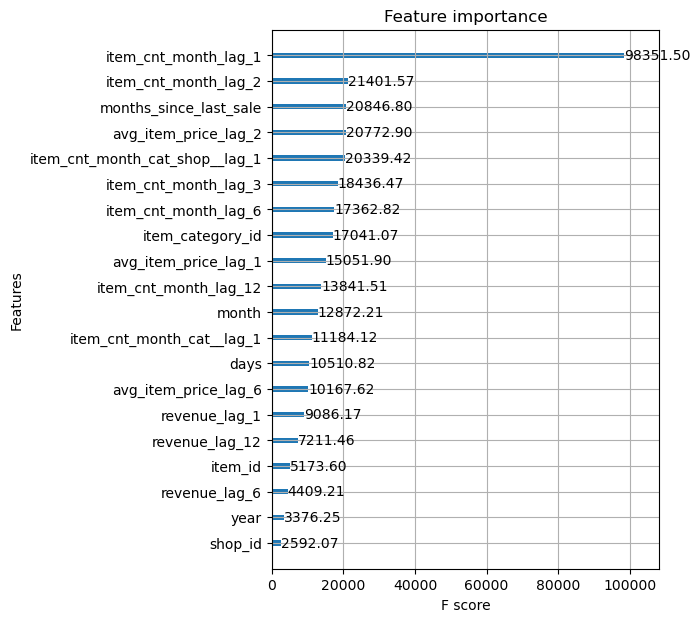

In [20]:
plot_features(model_best, (5, 7), importance_type="cover");

### All three graphs provide different answers; this means, that we need to determine which metric is the best for the dataset. I believe there are more accurate ways to calculate less biased feature importances 

## Permutation based feature importance

### First calculate X, y 

In [22]:
tscv = TimeSeriesSplit(n_splits=1)

for train_idx, test_idx in tscv.split(X_less_corr):
    X_new = X_less_corr.copy()
    X_new.drop('date_block_num', axis=1, inplace=True)
    X_train, X_test = X_new[train_idx], X_new[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

In [23]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(model_best, X_test, y_test)

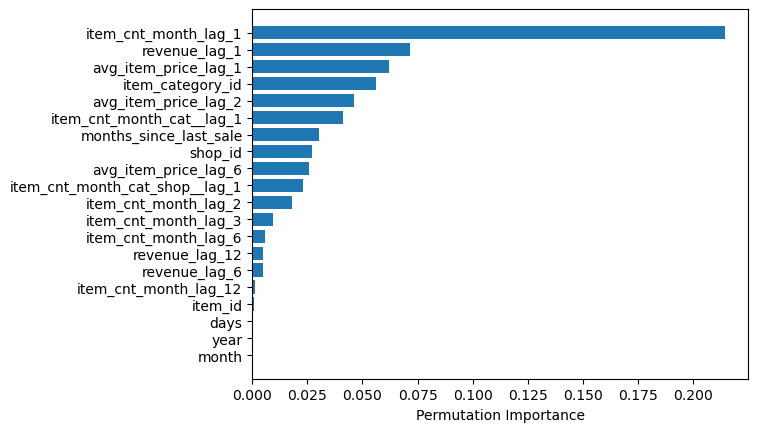

In [25]:
sorted_idx = perm.importances_mean.argsort()
plt.barh(X_test.columns[sorted_idx], perm.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance");

### Permutation-based method can be inaccurate with **highly correlated features** (it's still more or less a characteristic for our dataset because of some lagged features in it)

## **SHAP** is known to be one of the most consistent and accurate methods for calculating feature importances - let's use it now

In [38]:
from shap import TreeExplainer, plots

import shap

In [27]:
explainer = TreeExplainer(model_best, X_test)
shap_values = explainer(X_test)

100%|===================| 31527/31531 [09:28<00:00]        

In [29]:
type(shap_values)

shap._explanation.Explanation

In [37]:
shap_values2 = explainer.shap_values(X_test)

100%|===================| 31511/31531 [09:24<00:00]        

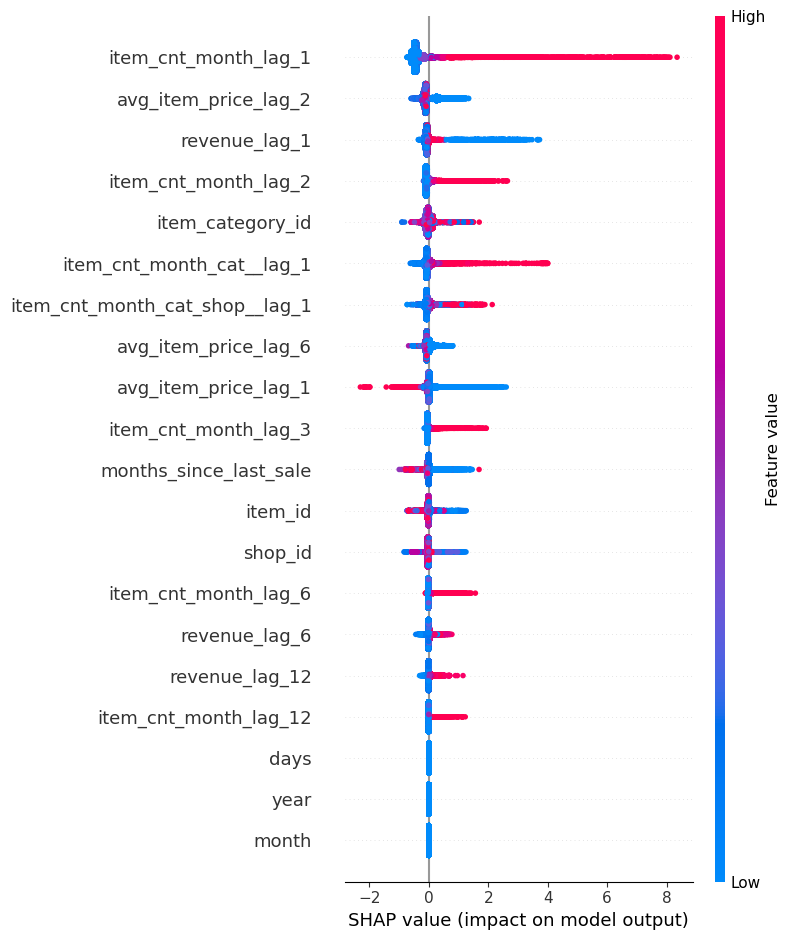

In [40]:
fig = shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("shap_summary.png", dpi=700)

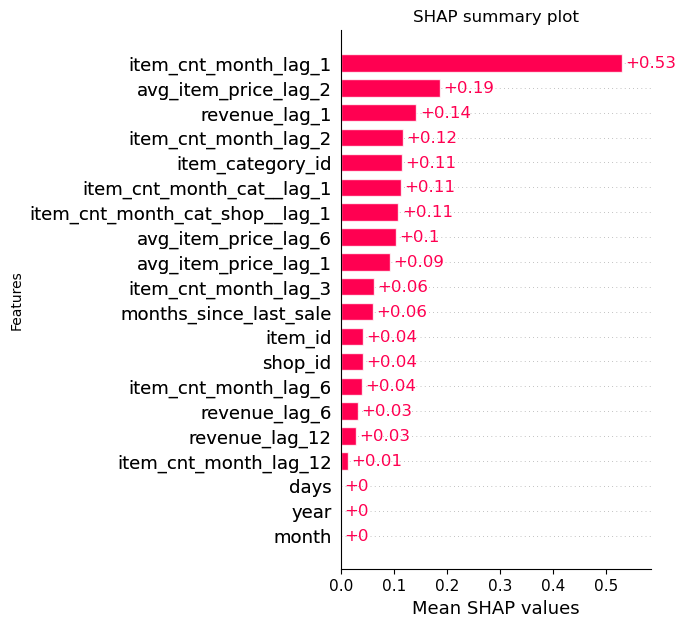

In [33]:
fig, ax = plt.subplots()

plots.bar(shap_values, show=False, max_display=20)
fig.set_size_inches(4, 7)
ax.set_title("SHAP summary plot")
ax.set_xlabel("Mean SHAP values")
ax.set_ylabel("Features");

In [34]:
plt.savefig("shap_summary.png", dpi=700)

<Figure size 640x480 with 0 Axes>

In [35]:
shap_values.feature_names

['shop_id',
 'item_id',
 'month',
 'year',
 'item_category_id',
 'months_since_last_sale',
 'revenue_lag_1',
 'revenue_lag_6',
 'revenue_lag_12',
 'item_cnt_month_lag_1',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_cnt_month_lag_6',
 'item_cnt_month_lag_12',
 'item_cnt_month_cat__lag_1',
 'item_cnt_month_cat_shop__lag_1',
 'days',
 'avg_item_price_lag_1',
 'avg_item_price_lag_2',
 'avg_item_price_lag_6']